In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from xgboost import XGBRegressor,XGBClassifier
from sklearn.metrics import log_loss
from sklearn.svm import LinearSVC,LinearSVR,SVC,SVR
from scipy.stats import norm,skew

# Setting the number of columns to display
pd.set_option('display.max_columns', None)
# year
yr=2014

In [2]:
cities=pd.read_csv("WPrelimData2018/WCities_PrelimData2018.csv")
game_cities=pd.read_csv("WPrelimData2018/WGameCities_PrelimData2018.csv")

tourney_seeds=pd.read_csv("WDataFiles/WNCAATourneySeeds.csv")

regular_season_results=pd.read_csv("WPrelimData2018/WRegularSeasonCompactResults_PrelimData2018.csv")
detailed_regular_season=pd.read_csv("WPrelimData2018/WRegularSeasonDetailedResults_PrelimData2018.csv")

tourney_results=pd.read_csv("WPrelimData2018/WNCAATourneyCompactResults_PrelimData2018.csv")
detailed_tourney=pd.read_csv("WPrelimData2018/WNCAATourneyDetailedResults_PrelimData2018.csv")


sample_submission=pd.read_csv("WDataFiles/WSampleSubmissionStage1.csv")

print("Regular season results",regular_season_results.shape)
print("Tourney results",tourney_results.shape)

Regular season results (101450, 8)
Tourney results (1260, 8)


In [3]:
# for extraction of seed and region
def extract_seedint(seed):
    k=int(seed[1:])
    return k;
def region(seed):
    return seed[0];
tourney_seeds['seed_int']=tourney_seeds['Seed'].apply(extract_seedint)
tourney_seeds['region']=tourney_seeds['Seed'].apply(region)
tourney_seeds.drop(columns=['Seed'],inplace=True)
tourney_seeds.head(10)

,Season,TeamID,seed_int,region
0,1998,3330,1,W
1,1998,3163,2,W
2,1998,3112,3,W
3,1998,3301,4,W
4,1998,3272,5,W
5,1998,3438,6,W
6,1998,3208,7,W
7,1998,3307,8,W
8,1998,3304,9,W
9,1998,3203,10,W


In [4]:
# merging the tournament results
winseeds = tourney_seeds.rename(columns={'TeamID':'WTeamID', 'seed_int':'WSeed','region':'WRegion'})
lossseeds = tourney_seeds.rename(columns={'TeamID':'LTeamID', 'seed_int':'LSeed','region':'LRegion'})
df_dummy = pd.merge(left=tourney_results, right=winseeds, how='left', on=['Season', 'WTeamID'])
tourney_results= pd.merge(left=df_dummy, right=lossseeds,how='left',on=['Season', 'LTeamID'])
tourney_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,WRegion,LSeed,LRegion
0,1998,137,3104,94,3422,46,H,0,2,X,15,X
1,1998,137,3112,75,3365,63,H,0,3,W,14,W
2,1998,137,3163,93,3193,52,H,0,2,W,15,W
3,1998,137,3198,59,3266,45,H,0,7,Y,10,Y
4,1998,137,3203,74,3208,72,A,0,10,W,7,W


In [5]:
df_dummy = pd.merge(left=regular_season_results, right=winseeds, how='left', on=['Season', 'WTeamID'])
regular_season_results= pd.merge(left=df_dummy, right=lossseeds,how='left',on=['Season', 'LTeamID'])
regular_season_results.drop(columns=['WRegion','LRegion'],inplace=True)
regular_season_results['WSeed'].fillna(0,inplace=True)
regular_season_results['LSeed'].fillna(0,inplace=True)
regular_season_results.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WSeed,LSeed
0,1998,18,3104,91,3202,41,H,0,2.0,0.0
1,1998,18,3163,87,3221,76,H,0,2.0,14.0
2,1998,18,3222,66,3261,59,H,0,0.0,0.0
3,1998,18,3307,69,3365,62,H,0,8.0,14.0
4,1998,18,3349,115,3411,35,H,0,0.0,0.0


In [6]:
temp1=pd.DataFrame()
temp1['TeamID']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('WTeamID').WScore.sum().index
temp1['WScore']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('WTeamID').WScore.sum().values

temp2=pd.DataFrame()
temp2['TeamID']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('LTeamID').LScore.sum().index
temp2['LScore']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('LTeamID').LScore.sum().values

temp=pd.merge(left=temp1,right=temp2,how='outer',on=['TeamID'])
temp['av_pps']=temp['WScore']+temp['LScore']
temp.drop(columns=['WScore','LScore'],inplace=True)

temp1=pd.DataFrame()
temp1['TeamID']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('WTeamID').LScore.sum().index
temp1['LScore']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('WTeamID').LScore.sum().values

temp2=pd.DataFrame()
temp2['TeamID']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('LTeamID').WScore.sum().index
temp2['WScore']=regular_season_results.loc[regular_season_results['Season']<=yr].groupby('LTeamID').WScore.sum().values

temp_pag=pd.merge(left=temp1,right=temp2,how='outer',on=['TeamID'])
temp_pag['av_ppa']=temp_pag['WScore']+temp_pag['LScore']
temp_pag.drop(columns=['WScore','LScore'],inplace=True)

temp=pd.merge(left=temp,right=temp_pag,how='outer',on=['TeamID'])

temp1=pd.DataFrame()
temp1['TeamID']=regular_season_results.loc[regular_season_results['Season']<=yr,'WTeamID'].value_counts().index
temp1['wmatches']=regular_season_results.loc[regular_season_results['Season']<=yr,'LTeamID'].value_counts().values

temp2=pd.DataFrame()
temp2['TeamID']=regular_season_results.loc[regular_season_results['Season']<=yr,'LTeamID'].value_counts().index
temp2['lmatches']=regular_season_results.loc[regular_season_results['Season']<=yr,'LTeamID'].value_counts().values

temp_mat=pd.merge(left=temp1,right=temp2,how='outer',on=['TeamID'])
temp_mat['number']=temp_mat['wmatches']+temp_mat['lmatches']
temp_mat.drop(columns=['wmatches','lmatches'],inplace=True)
temp_mat.sort_values(by=['TeamID'],axis=0,inplace=True)
temp=pd.merge(left=temp,right=temp_mat,how='outer',on=['TeamID'])

# calculationg the average
temp['av_pps']=temp['av_pps']/temp['number']
temp['av_ppa']=temp['av_ppa']/temp['number']
temp.drop(columns='number',inplace=True)
temp.head()

,TeamID,av_pps,av_ppa
0,3101,46.000000,45.942857
1,3102,53.552301,68.803347
2,3103,61.820663,67.838207
3,3104,64.586481,65.900596
4,3105,58.070175,62.850877


In [7]:
ppa1=temp.rename(columns={'TeamID':'WTeamID','av_pps':'Wav_pps','av_ppa':'Wav_ppa'})
ppa2=temp.rename(columns={'TeamID':'LTeamID','av_pps':'Lav_pps','av_ppa':'Lav_ppa'})

df_dummy=pd.merge(left=tourney_results,right=ppa1,how='left',on=['WTeamID'])
tourney_results=pd.merge(left=df_dummy,right=ppa2,how='left',on=['LTeamID'])

df_dummy=pd.merge(left=regular_season_results,right=ppa1,how='left',on=['WTeamID'])
regular_season_results=pd.merge(left=df_dummy,right=ppa2,how='left',on=['LTeamID'])

In [8]:
wins=tourney_results.loc[tourney_results['Season']<yr,['Season','WSeed','LSeed','WScore','LScore','Wav_pps','Wav_ppa','Lav_pps','Lav_ppa']]
wins['SeedDiff']=wins['WSeed']-wins['LSeed']
wins['ScoreDiff']=wins['WScore']-wins['LScore']

wins['ppsDiff']=wins['Wav_pps']-wins['Lav_pps']
wins['ppaDiff']=wins['Wav_ppa']-wins['Lav_ppa']

wins.drop(columns=['WSeed','LSeed','WScore','LScore','Season','Wav_pps','Wav_ppa','Lav_pps','Lav_ppa'],inplace=True)

wins['Result']=1
wins['Result']=wins['Result'].astype(int)

losses=-wins
losses['Result']=0

data=pd.concat([wins,losses],axis=0)
data['Type']=1             # tournnament games
data.head()

,SeedDiff,ScoreDiff,ppsDiff,ppaDiff,Result,Type
0,-13.0,48.0,2.321135,2.197626,1,1
1,-11.0,12.0,2.082998,1.191592,1,1
2,-13.0,41.0,38.735239,3.133738,1,1
3,-3.0,14.0,-1.175608,-1.532343,1,1
4,3.0,2.0,-8.318352,-2.344714,1,1


In [9]:
# wins=regular_season_results.loc[regular_season_results['Season']<yr,['Season','WSeed','LSeed','WScore','LScore','Wav_pps','Wav_ppa','Lav_pps','Lav_ppa']]
# wins['SeedDiff']=wins['WSeed']-wins['LSeed']
# wins['ScoreDiff']=wins['WScore']-wins['LScore']
# wins.drop(columns=['WSeed','LSeed','WScore','LScore','Season'],inplace=True)

# wins['Result']=1
# wins['Result']=wins['Result'].astype(int)

# losses=-wins
# losses['Result']=0

# print(wins.shape)
# com=pd.concat([wins,losses],axis=0,ignore_index=True)
# com['Type']=0  # regular season
# com.head()
# com=pd.concat([data,com],axis=0,ignore_index=True)
# print(com.shape)
# com.head()

In [10]:
data.corr()

,SeedDiff,ScoreDiff,ppsDiff,ppaDiff,Result,Type
SeedDiff,1.000000,-0.751288,-0.605192,-0.383949,-0.622004,NaN
ScoreDiff,-0.751288,1.000000,0.600814,0.320239,0.807647,NaN
ppsDiff,-0.605192,0.600814,1.000000,0.705328,0.450661,NaN
ppaDiff,-0.383949,0.320239,0.705328,1.000000,0.250401,NaN
Result,-0.622004,0.807647,0.450661,0.250401,1.000000,NaN
Type,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
X_train=data.iloc[:,[0,2,3]].values
y_train=data.iloc[:,1].values
print(X_train.shape,y_train.shape)

(2016, 3) (2016,)


In [12]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42)
print("For regression ")
print("The training shape is",X_train.shape," and the label shape is",y_train.shape)
print("The validation shape is",X_val.shape," and the label shape is",y_val.shape)

For regression 
The training shape is (1814, 3)  and the label shape is (1814,)
The validation shape is (202, 3)  and the label shape is (202,)


My plan is to predict the score differences and this can be used to predict the score differences in the test data 

In [13]:
lr=LinearRegression()
lr.fit(X_train,y_train)
print("The training Score is",lr.score(X_train,y_train))
print("The validation Score is",lr.score(X_val,y_val))

The training Score is 0.608243696714
The validation Score is 0.624507648684


In [14]:
rf=RandomForestRegressor(random_state=42)
rf.fit(X_train,y_train)
print("The training Score is",rf.score(X_train,y_train))
print("The validation Score is",rf.score(X_val,y_val))

The training Score is 0.914207922652
The validation Score is 0.504781952517


In [15]:
xgr=XGBRegressor(random_state=42)
xgr.fit(X_train,y_train)
print("The training Score is",xgr.score(X_train,y_train))
print("The validation Score is",xgr.score(X_val,y_val))

The training Score is 0.678685562534
The validation Score is 0.624177669458


In [16]:
pred_data=data.iloc[:,[0,2,3]].values
data['DiffbyRegressor']=lr.predict(pred_data)  # if i make xgr the log loss of the classfier becomes 0.39 and for lr log loss is 0.4419
data.head()                               

,SeedDiff,ScoreDiff,ppsDiff,ppaDiff,Result,Type,DiffbyRegressor
0,-13.0,48.0,2.321135,2.197626,1,1,20.863790
1,-11.0,12.0,2.082998,1.191592,1,1,18.091808
2,-13.0,41.0,38.735239,3.133738,1,1,36.181206
3,-3.0,14.0,-1.175608,-1.532343,1,1,5.235997
4,3.0,2.0,-8.318352,-2.344714,1,1,-7.175473


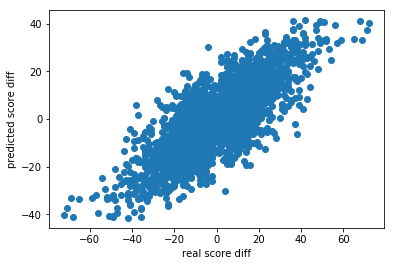

In [17]:
plt.scatter(data['ScoreDiff'],data['DiffbyRegressor'])
plt.xlabel("real score diff")
plt.ylabel("predicted score diff")
plt.show()

I will build a classifier on the data using Season,SeedDiff,ScoreDiff by regressor. 

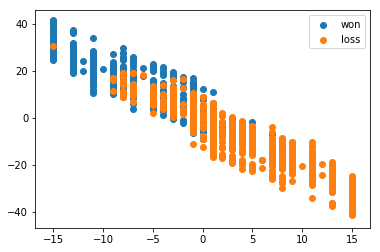

In [18]:
plt.scatter(data.loc[data['Result']==1,'SeedDiff'],data.loc[data['Result']==1,'DiffbyRegressor'],label='won')
plt.scatter(data.loc[data['Result']==0,'SeedDiff'],data.loc[data['Result']==0,'DiffbyRegressor'],label='loss')
plt.legend()
plt.show()

In [19]:
X_train=data.iloc[:,[0,6]].values
y_train=data.iloc[:,4].values
print(X_train.shape,y_train.shape)

(2016, 2) (2016,)


In [20]:
X_train,X_val,y_train,y_val=train_test_split(X_train,y_train,test_size=0.1,random_state=42,shuffle=True)

print("The training shape is",X_train.shape," and the label shape is",y_train.shape)
print("The validation shape is",X_val.shape," and the label shape is",y_val.shape)

The training shape is (1814, 2)  and the label shape is (1814,)
The validation shape is (202, 2)  and the label shape is (202,)


# Classifiers

## LOSGISTIC REGRESSION

In [21]:
param={'C':[0.01,0.03,0.06,0.1,0.3,0.6,1]}
lr=LogisticRegression()
gridsearch=GridSearchCV(lr,param_grid=param,scoring='neg_log_loss',cv=5)
gridsearch.fit(X_train,y_train)
print("The best value of C is",gridsearch.best_params_)

The best value of C is {'C': 0.01}


In [22]:
lr=LogisticRegression(C=gridsearch.best_params_['C'])
lr.fit(X_train,y_train)
print("The training log loss is",log_loss(y_train,lr.predict_proba(X_train)[:,1]))
print("The validation log los is",log_loss(y_val,lr.predict_proba(X_val)[:,1]))

The training log loss is 0.442604897526
The validation log los is 0.449195564035


In [23]:
xgc=XGBClassifier(n_estimators=100,random_state=42)
xgc.fit(X_train,y_train)
print("The training log loss is",log_loss(y_train,xgc.predict_proba(X_train)[:,1]))
print("The validation log los is",log_loss(y_val,xgc.predict_proba(X_val)[:,1]))

The training log loss is 0.402015013978
The validation log los is 0.452321237479


In [24]:
print("The training loss of the ensemble is",log_loss(y_train,0.5*xgc.predict_proba(X_train)[:,1]+0.5*lr.predict_proba(X_train)[:,1]))
print("The validation loss of the ensemble is",log_loss(y_val,0.5*xgc.predict_proba(X_val)[:,1]+0.5*lr.predict_proba(X_val)[:,1]))

The training loss of the ensemble is 0.419098516114
The validation loss of the ensemble is 0.449141991624


## TEST PREPROCESSING

In [25]:
test=pd.DataFrame(columns=['Season','WTeamID','LTeamID'])
for i in sample_submission.index:
    season,wid,lid=map(int,sample_submission['ID'][i].split("_"))
    test.loc[i,'Season']=season
    test.loc[i,'WTeamID']=wid
    test.loc[i,'LTeamID']=lid

test['Season']=test['Season'].astype(int)
test['WTeamID']=test['WTeamID'].astype(int)
test['LTeamID']=test['LTeamID'].astype(int)
test.head()

,Season,WTeamID,LTeamID
0,2014,3103,3107
1,2014,3103,3113
2,2014,3103,3119
3,2014,3103,3124
4,2014,3103,3140


In [26]:
df_dummy=pd.merge(left=test,right=winseeds,how='left',on=['Season','WTeamID'])
test=pd.merge(left=df_dummy,right=lossseeds,how='left',on=['Season','LTeamID'])

df_dummy=pd.merge(left=test,right=ppa1,how='left',on=['WTeamID'])
test=pd.merge(left=df_dummy,right=ppa2,how='left',on=['LTeamID'])


test['SeedDiff']=test['WSeed']-test['LSeed']
test['ppsDiff']=test['Wav_pps']-test['Lav_pps']
test['ppaDiff']=test['Wav_ppa']-test['Lav_ppa']
test.drop(columns=['WRegion','LRegion','WSeed','LSeed','Season','Wav_pps','Wav_ppa','Lav_pps','Lav_ppa'],inplace=True)


test['Type']=1
test.head()

,WTeamID,LTeamID,SeedDiff,ppsDiff,ppaDiff,Type
0,3103,3107,-2,3.688078,8.402252,1
1,3103,3113,4,-6.413905,5.128330,1
2,3103,3119,0,1.708397,7.453591,1
3,3103,3124,11,-21.696359,0.833951,1
4,3103,3140,1,-8.544316,4.258038,1


# predictions of regressor

In [27]:
# usedd random forest regressor predictions
X_test=test.iloc[:,[2,3,4]].values
test['DiffbyRegressor']=xgr.predict(X_test)
test.head()

,WTeamID,LTeamID,SeedDiff,ppsDiff,ppaDiff,Type,DiffbyRegressor
0,3103,3107,-2,3.688078,8.402252,1,0.539824
1,3103,3113,4,-6.413905,5.128330,1,-14.853702
2,3103,3119,0,1.708397,7.453591,1,-7.580558
3,3103,3124,11,-21.696359,0.833951,1,-29.653671
4,3103,3140,1,-8.544316,4.258038,1,-10.397937


In [28]:
data.head()

,SeedDiff,ScoreDiff,ppsDiff,ppaDiff,Result,Type,DiffbyRegressor
0,-13.0,48.0,2.321135,2.197626,1,1,20.863790
1,-11.0,12.0,2.082998,1.191592,1,1,18.091808
2,-13.0,41.0,38.735239,3.133738,1,1,36.181206
3,-3.0,14.0,-1.175608,-1.532343,1,1,5.235997
4,3.0,2.0,-8.318352,-2.344714,1,1,-7.175473


## predictions of classifier

In [29]:
X_test=test.iloc[:,[5,6]].values
sample_submission['Pred']=xgc.predict_proba(X_test)[:,1]
sample_submission.head()

,ID,Pred
0,2014_3103_3107,0.512433
1,2014_3103_3113,0.151751
2,2014_3103_3119,0.285175
3,2014_3103_3124,0.013325
4,2014_3103_3140,0.353971


In [30]:
sample_submission.to_csv("Trying_something_new.csv",index=False)
print("Done")

Done
